# Resaercher Evaluation - H-index

# 説明

## h-index（h指数）とは何か？

h-indexはアメリカの物理学者Jorge E. Hirsch氏が2005年に発表した研究者の評価指標である。

> 要旨：私は、研究者の科学的産出を特徴づける有用な指標として、被引用数がhより大きい論文の数と定義される指数hを提案した。
> 
>> Abstract: I propose the index h, defined as the number of papers with citation number ≥h, as a useful index to characterize the scientific output of a researcher. 
> 
> Hirsch, J. E. (2005). An index to quantify an individual's scientific research output. Proceedings of the National Academy of Sciences, 102(46), 16569-16572. https://www.pnas.org/doi/abs/10.1073/pnas.0507655102

ある科学者が発表したN本論文の中で、**h回以上引用された論文がh本あり**、それ以外のN-h本論文の被引用数が全部hより小さい場合、その科学者の**h-indexはh**である。
 
例えば、h-index=**20**というのは、被引用数が**20**以上の論文が**20**本あり、それ以外の論文はすべて被引用数が20本未満だということである。

## なぜ提案したのか？どうして重要なのか？

リソースが限られた世界で、個人の科学的成果の累積的影響力を定量化することは、評価や比較のために必要とされる。

|指数|長所|短所|
|:-|:-|:-|
|発表論文数(N)|研究者の生産力を測る|論文の影響力が無視される|
|総被引用数(C)|研究者の総影響力を測る|1. 少数の大ヒット論文に歪まれる可能性があり、特に、これらの大ヒットが共著である場合、個人のキャリア全体を代表していない可能性がある。<br>2. 引用度の高いレビューに過度な重みを与えている。|
|平均被引用数(C/N)|異なる年齢の科学者を比較することができる|1. 生産性が高い研究者に不利になる。2. 高被引用数の論文に歪まれる可能性がある。|
|被引用数≥cの論文数|上記の指標の欠点を克服し、広範囲かつ持続的な影響を測る。|cは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|
|上位q個の論文の被引用数|上記の指標の欠点をほとんど克服する。|1. 単一の数値ではないため、科学者を比較するには困難である。<br>2. qは任意であり、一部の科学者に有利な一方で他の科学者には不利になる。|


# 算出

## 0. 準備：pyalex

In [ ]:
import sys
import os

%cd /content/sample_data/
!git clone https://github.com/ScisciJP/scisciJP2024_tutorial.git

sys.path.append('/content/sample_data/scisciJP2024_tutorial')
print(os.getcwd())
os.chdir('/content/sample_data/scisciJP2024_tutorial')
sys.path


In [ ]:
%pip install pyalex

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyalex
from pyalex import Works, Authors, Institutions
from pprint import pprint
import util

# pyalex.config.email = "your@email.address"
pyalex.config.email = "wangsiyuan1209@gmail.com"

def plot_citations(ax, citations, *,\
                   xlabel='Papers', ylabel='# Citations', title='',\
                   loglog=False, showline=False, h_index=0):
    
    markerline, stemlines, baseline = ax.stem(np.arange(1, len(citations) + 1), citations, basefmt=" ")
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    if loglog: 
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.set_xlim(0, len(citations) + 1)
        ax.set_ylim(0, max(citations) * 1.1)

    if showline:
        plt.setp(stemlines, 'color', 'skyblue')
        plt.setp(markerline, 'color', 'lightcoral')
    else:
        stemlines.remove()
        plt.setp(markerline, 'color', 'C0')
    
    if h_index!=0:
        lim=min(ax.get_xlim()[1],ax.get_ylim()[1])
        ax.plot([1, lim], [1, lim], ls="--", color='crimson')
        ax.plot([0, ax.get_xlim()[1]], [h_index, h_index], color='gray', linestyle='--')
        ax.plot([h_index, h_index], [0, ax.get_ylim()[1]], color='gray', linestyle='--')

## １. h-indexの計算方法：Dashun Wangを例に

In [ ]:
# 論文の被引用数をpyalexで獲得
name = "Dashun Wang"

authors_json = Authors().search_filter(display_name=name).select(["id"]).get()
authors_df = pd.DataFrame(authors_json)
author_id = authors_df.loc[0,"id"]

pyalexObj = Works().filter(author={"id":author_id},is_paratext=False)\
                .select(["cited_by_count"])\
                .sort(publication_date="asc")
citations_json = util.getAll(pyalexObj)
c_test= [entry['cited_by_count'] for entry in citations_json]

2it [00:01,  1.47it/s]


In [ ]:
# h-indexの算出
# 被引用数を大きい順に並べ替える
sorted_c_test = sorted(c_test, reverse=True)

# メソッド１：被引用数が論文のランキングより大きい論文を数える。
h_index = np.sum([c >= i + 1 for i, c in enumerate(sorted_c_test)])
print(f"The h-index of the researcher is: {h_index}. (method 1)\n")

# メソッド２：図に示したように、論文被引用数の曲線と45°直線の交点の横座標がh-index。
array = np.arange(1,len(sorted_c_test)+1)
h_index = np.max(np.minimum(sorted_c_test, array))
print(f"The h-index of the researcher is: {h_index}. (method 2)\n")

The h-index of the researcher is: 28. (method 1)

The h-index of the researcher is: 28. (method 2)



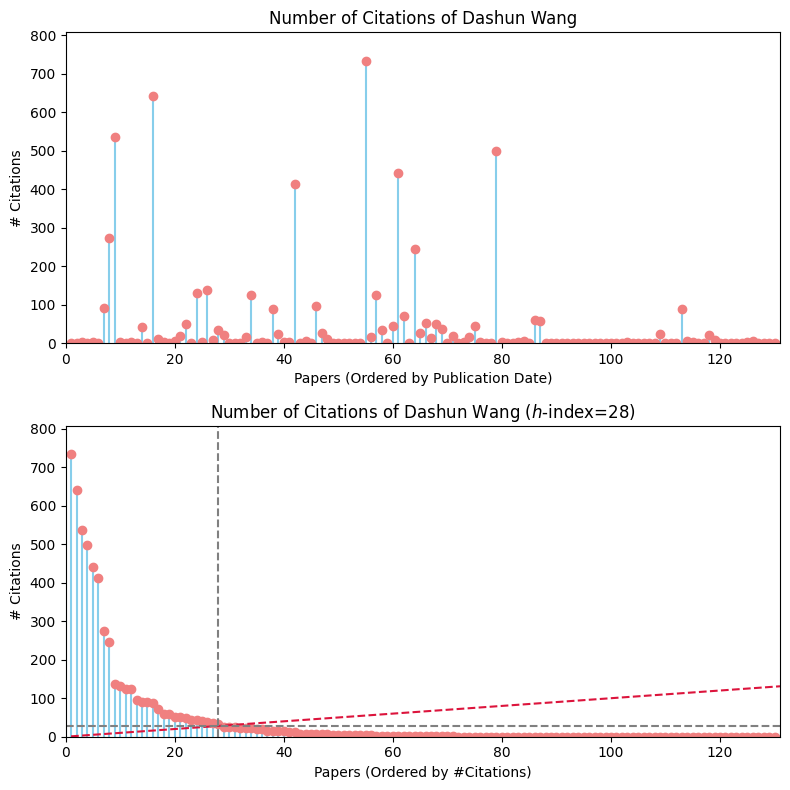

In [ ]:
# グラフを作成する
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
plot_citations(axs[0], c_test, showline=True,\
               xlabel='Papers (Ordered by Publication Date)',\
               title=f'Number of Citations of {name}')
plot_citations(axs[1], sorted_c_test, showline=True, h_index=h_index, \
               xlabel='Papers (Ordered by #Citations)', \
               title=f'Number of Citations of {name} ($h$-index={h_index})')
plt.tight_layout()
plt.show()

## 2. 実データからh-indexの算出

In [ ]:
def calculate_h_index(citations):
    if len(citations)==0:
        return 0
    else:
        citations = np.array(citations)
        citations[::-1].sort()
        array = np.arange(1,citations.size+1)
        h_index = np.max(np.minimum(citations, array))
        return h_index

In [ ]:
# アインシュタインを検索する
name = "Albert Einstein"

authors_json = Authors().search_filter(display_name=name)\
            .select(["id","display_name","relevance_score","works_count","cited_by_count","summary_stats"]).get()
authors_df = pd.DataFrame(authors_json)
authors_df = authors_df.join(pd.DataFrame(authors_df['summary_stats'].tolist()))
authors_df = authors_df.drop(columns=['summary_stats'])

display(authors_df.head())

,id,display_name,relevance_score,works_count,cited_by_count,2yr_mean_citedness,h_index,i10_index
0,https://openalex.org/A5054034686,Albert Einstein,18914.02700,1019,48471,0.0,78,210
1,https://openalex.org/A5083138872,Albert Einstein,3508.72700,44,1589,0.0,10,11
2,https://openalex.org/A5052160352,Albert Einstein,1185.03200,2,165,0.0,1,1
3,https://openalex.org/A5055907730,Albert Einstein Fernandes Muritiba,978.85803,14,207,2.0,6,5
4,https://openalex.org/A5047005486,George Albert Einstein,695.72626,3,74,0.0,1,1


In [ ]:
# 検索結果から著者を指定する
i = 0
author_id = authors_df.loc[i,"id"]
author_name = authors_df.loc[i,"display_name"]

# 著者データを確認する
data = Authors()[author_id]
# 著者の最新の所属機関（ここでは同名の人が混ざっているため、表示されたのはあのアインシュタインの所属機関ではない）
institutions = [entry['display_name'] for entry in data['last_known_institutions']]
print('Last known institutions of the select author:')
pprint(institutions)
# 著者が発表した論文のテーマ
concepts = [entry['display_name'] for entry in data['x_concepts']]
print('\nConcepts of the select author:')
pprint(concepts)

Last known institutions of the select author:
["Saint Peter's University"]

Concepts of the select author:
['Physics',
 'Philosophy',
 'Quantum mechanics',
 'Mathematics',
 'Classical mechanics',
 'Computer science',
 'Mathematical physics',
 'Art',
 'Einstein',
 'Political science']


In [ ]:
# 著者の論文データを抽出する
pyalexObj = Works().filter(author={"id":author_id},is_paratext=False)\
                .select(["cited_by_count"])\
                .sort(cited_by_count="desc")
citations_json = util.getAll(pyalexObj)
citations = np.array([entry['cited_by_count'] for entry in citations_json])

7it [00:04,  1.49it/s]


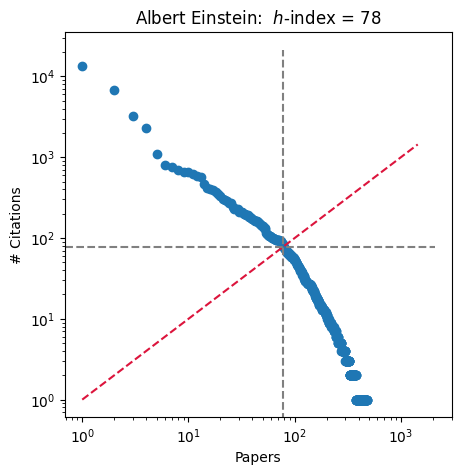

In [ ]:
# 被引用数からh-indexを算出する
h_index = calculate_h_index(citations)

# グラフを作成する
fig, ax = plt.subplots(figsize=(5, 5))
title = f'{author_name}:  $h$-index = {h_index}'
plot_citations(ax, citations, h_index=h_index, title=title, loglog=True)
plt.show()

# 探索

## 3．重回帰分析によるh-index予測

2016年時点のデータに基づいて2024年のh-indexを予測する。  
(ただし、orcidがあり、発表論文数>3かつ被引用数>10の著者に絞る)
- X：
    - career_age: 2024 - min(publication_year)
    - sqrt(cited_past_5_yrs): get from 'counts_by_year' (2012-2016)
    - affiliation_h_index: institution.summary_stats.h_index
- Y:
    - h_index: 'author.summary_stats.h_index'

### 学習データの準備

In [ ]:
# get a list of #citations in [from_year, to_year] of works published in [from_year, to_year]
def get_citations(works_json, from_year, to_year):
        n = 0
        citations = []
        for work in works_json:
            if (from_year <= work['publication_year'] <= to_year):
                n += 1
                cited_by_count_after = sum(entry['cited_by_count'] for entry in work['counts_by_year'] 
                              if entry['year'] > to_year)
                citations.append(work['cited_by_count'] - cited_by_count_after)
            else:
                continue
        return citations

In [ ]:
# Sample authors of cited_by_count>10
pyalexObj = Authors().sample(100, seed=42)\
                .filter(cited_by_count=">10")\
                .filter(works_count=">3")\
                .filter(has_orcid=True)\
                .select(['id','display_name','summary_stats','affiliations','counts_by_year'])
authors_json = util.getAll(pyalexObj)
authors_df = pd.DataFrame(authors_json)

# Get h_index
authors_df['h_index'] = authors_df['summary_stats'].apply(lambda x:x['h_index'])
authors_df = authors_df.drop(columns=['summary_stats'])

2it [00:02,  1.04s/it]


In [ ]:
authors_df.head()

,id,display_name,affiliations,counts_by_year,h_index
0,https://openalex.org/A5004172290,Yoichi Tanaka,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",8
1,https://openalex.org/A5086049530,Fang Yao,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",23
2,https://openalex.org/A5015759381,Yanling Feng,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",2
3,https://openalex.org/A5020752511,Yazhou Jiang,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 1, 'cited_by_co...",12
4,https://openalex.org/A5039070324,Kyohoon Sim,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",6


In [ ]:
authors_df[['career_age','cited_past_5yrs','affiliation_h_index']] = -1
authors_df[['cited_first_5yrs','works_first_5yrs','h_index_first_5yrs']] = -1
authors_df['cited_per_work_first_5yrs'] = -1.0
authors_df[['cited_first_10yrs','cited_6to10yrs']] = -1
predictor_year = 2016

for i, author in authors_df.iterrows():
    if (i)%10==0: print(i)

    pyalexObj = Works().filter(author={"id":author["id"]},is_paratext=False)\
                       .select(['cited_by_count','counts_by_year','publication_year'])\
                       .sort(publication_year="asc")
    works_json = util.getAll(pyalexObj)
    if works_json==[]:
        continue

    #-------------for Section 3--------------
    # Calculate career_age
    first_publication_year = works_json[0]["publication_year"]
    authors_df.loc[i,'career_age'] = 2024 - first_publication_year
    
    if first_publication_year <= (predictor_year - 4):
        # Calculate cited_past_5yrs (citation earned in the past 5 years before 2016 (include, i.e. [2012,2016]))    
        authors_df.loc[i,'cited_past_5yrs'] = sum(entry['cited_by_count'] for entry in author['counts_by_year']
                                                if (predictor_year - 4) <= entry['year'] <= predictor_year)
        # Calculate affiliation_h_index (h-index of affiliations the author belongs to in 'predictor_year')
        affiliations = author["affiliations"]
        if affiliations:
            year = predictor_year
            found = False
            authors_df.loc[i,'affiliation_h_index'] = -1
            while (not found) and (year > predictor_year-5):
                for af in affiliations:
                    if year in af['years']:
                        affiliation_h_index = Institutions()[af['institution']['id']]['summary_stats']['h_index']
                        if authors_df.loc[i,'affiliation_h_index'] < affiliation_h_index:
                            authors_df.loc[i,'affiliation_h_index'] = affiliation_h_index
                        found = True
                year -= 1
        else:
            pass
    else:
        pass
        
    #-------------for Section 4--------------
    # Calculate indices in the first 5 (and 10) years of the career                
    if (first_publication_year+5 >= 2012) and (first_publication_year+10 <= 2024):
        # Calculate indices in the first 5 years of the career
        citations_first_5yrs = get_citations(works_json, first_publication_year, first_publication_year+4)
        authors_df.loc[i,'works_first_5yrs']=len(citations_first_5yrs) 
        authors_df.loc[i,'cited_first_5yrs']=sum(citations_first_5yrs) 
        authors_df.loc[i,'cited_per_work_first_5yrs']=authors_df.loc[i,'cited_first_5yrs']/authors_df.loc[i,'works_first_5yrs']
        authors_df.loc[i,'h_index_first_5yrs']=calculate_h_index(citations_first_5yrs)
        # Calculate indices in the first 10 years of the career
        authors_df.loc[i,'cited_first_10yrs']=sum(get_citations(works_json, first_publication_year, first_publication_year+9)) 
        # Calculate indices in the 6th to 10th years of the career
        authors_df.loc[i,'cited_6to10yrs']=sum(get_citations(works_json, first_publication_year+5, first_publication_year+9)) 

0


2it [00:01,  1.56it/s]
2it [00:01,  1.43it/s]
2it [00:01,  1.50it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.50it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.40it/s]
2it [00:01,  1.54it/s]
2it [00:01,  1.51it/s]


10


2it [00:01,  1.50it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.56it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.50it/s]


20


2it [00:01,  1.45it/s]
2it [00:01,  1.36it/s]
2it [00:01,  1.51it/s]
3it [00:02,  1.49it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.50it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.53it/s]


30


2it [00:01,  1.49it/s]
2it [00:01,  1.49it/s]
2it [00:01,  1.55it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.53it/s]
2it [00:01,  1.52it/s]
2it [00:01,  1.50it/s]
2it [00:01,  1.50it/s]
2it [00:01,  1.55it/s]
2it [00:01,  1.34it/s]


40


2it [00:01,  1.50it/s]
2it [00:01,  1.51it/s]
2it [00:01,  1.53it/s]
5it [00:03,  1.50it/s]
2it [00:01,  1.48it/s]
5it [00:03,  1.46it/s]
2it [00:01,  1.48it/s]
2it [00:01,  1.49it/s]
3it [00:01,  1.50it/s]
2it [00:01,  1.58it/s]


50


2it [00:01,  1.51it/s]
2it [00:01,  1.54it/s]
3it [00:01,  1.51it/s]
2it [00:01,  1.48it/s]
2it [00:01,  1.52it/s]
2it [00:01,  1.48it/s]
2it [00:01,  1.48it/s]
2it [00:01,  1.50it/s]
2it [00:01,  1.10it/s]
2it [00:01,  1.21it/s]


60


2it [00:01,  1.04it/s]
2it [00:01,  1.34it/s]
2it [00:01,  1.17it/s]
2it [00:01,  1.05it/s]
2it [00:02,  1.01s/it]
2it [00:01,  1.20it/s]
3it [00:03,  1.00s/it]
2it [00:01,  1.15it/s]
2it [00:01,  1.05it/s]
2it [00:01,  1.27it/s]


70


2it [00:01,  1.05it/s]
2it [00:01,  1.15it/s]
2it [00:01,  1.37it/s]
2it [00:01,  1.20it/s]
2it [00:01,  1.31it/s]
4it [00:03,  1.09it/s]
2it [00:01,  1.18it/s]
3it [00:03,  1.13s/it]
2it [00:01,  1.17it/s]
2it [00:01,  1.22it/s]


80


2it [00:01,  1.36it/s]
2it [00:02,  1.01s/it]
2it [00:01,  1.28it/s]
2it [00:01,  1.26it/s]
2it [00:01,  1.26it/s]
2it [00:02,  1.00s/it]
2it [00:01,  1.13it/s]
2it [00:01,  1.10it/s]
2it [00:01,  1.18it/s]
2it [00:01,  1.17it/s]


90


2it [00:01,  1.33it/s]
2it [00:01,  1.14it/s]
2it [00:01,  1.07it/s]
2it [00:01,  1.13it/s]
2it [00:01,  1.10it/s]
2it [00:01,  1.11it/s]
2it [00:01,  1.31it/s]
2it [00:01,  1.38it/s]
3it [00:03,  1.07s/it]
2it [00:01,  1.15it/s]


In [ ]:
authors_df.head()

,id,display_name,affiliations,counts_by_year,h_index,career_age,cited_past_5yrs,affiliation_h_index,cited_first_5yrs,works_first_5yrs,h_index_first_5yrs,cited_per_work_first_5yrs,cited_first_10yrs,cited_6to10yrs
0,https://openalex.org/A5004172290,Yoichi Tanaka,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",8,57,30,132,-1,-1,-1,-1.0,-1,-1
1,https://openalex.org/A5086049530,Fang Yao,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",23,27,1114,498,-1,-1,-1,-1.0,-1,-1
2,https://openalex.org/A5015759381,Yanling Feng,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",2,2,-1,-1,-1,-1,-1,-1.0,-1,-1
3,https://openalex.org/A5020752511,Yazhou Jiang,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 1, 'cited_by_co...",12,8,-1,-1,-1,-1,-1,-1.0,-1,-1
4,https://openalex.org/A5039070324,Kyohoon Sim,[{'institution': {'id': 'https://openalex.org/...,"[{'year': 2024, 'works_count': 0, 'cited_by_co...",6,13,1,-1,0,1,0,0.0,36,35


In [ ]:
authors_valid=authors_df[(authors_df['cited_past_5yrs']>=0) & (authors_df['affiliation_h_index']>=0)]
print(f'Number of valid data for regression: {authors_valid.shape[0]}')

Number of valid data for regression: 65


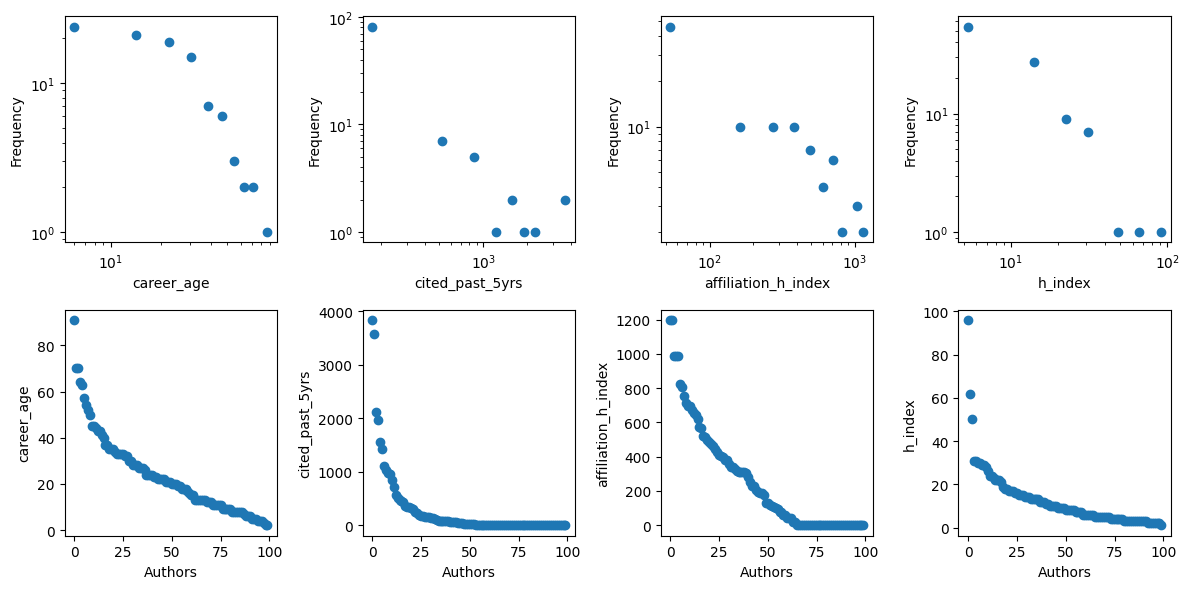

In [ ]:
columns = ['career_age','cited_past_5yrs','affiliation_h_index','h_index']
fig, axs = plt.subplots(2,4,figsize=(12,6))

# Plot distribution of frequency on 'career_age','cited_past_5yrs','affiliation_h_index','h_index'
for i, col in enumerate(columns):
    ax = axs[0,i]
    num_bins = 10
    binned_frequencies, bin_edges = np.histogram(authors_df[col], bins=num_bins+1)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    ax.scatter(bin_centers, binned_frequencies, marker='o')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xscale('log')
    ax.set_yscale('log')

# Plot distribution of 'career_age','cited_past_5yrs','affiliation_h_index','h_index' on authors
for i, col in enumerate(columns):
    ax = axs[1,i]
    ranking = authors_df[col].copy()
    ranking = sorted(ranking)[::-1]
    ax.scatter(np.arange(0, len(ranking)), ranking) 
    ax.set_xlabel('Authors')
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

### 学習と予測

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Define X and y of multiple regression analysis
X = authors_valid[['career_age','affiliation_h_index']].copy()  # predictors
X['sqrt_cited_past_5yrs']=np.sqrt(authors_valid['cited_past_5yrs'])
y = authors_valid['h_index']  # target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

model = LinearRegression()

# Fitting
model.fit(X_train, y_train)

# Predictions on the training set
y_train_pred = model.predict(X_train)

# Predictions on the test set
y_test_pred = model.predict(X_test)

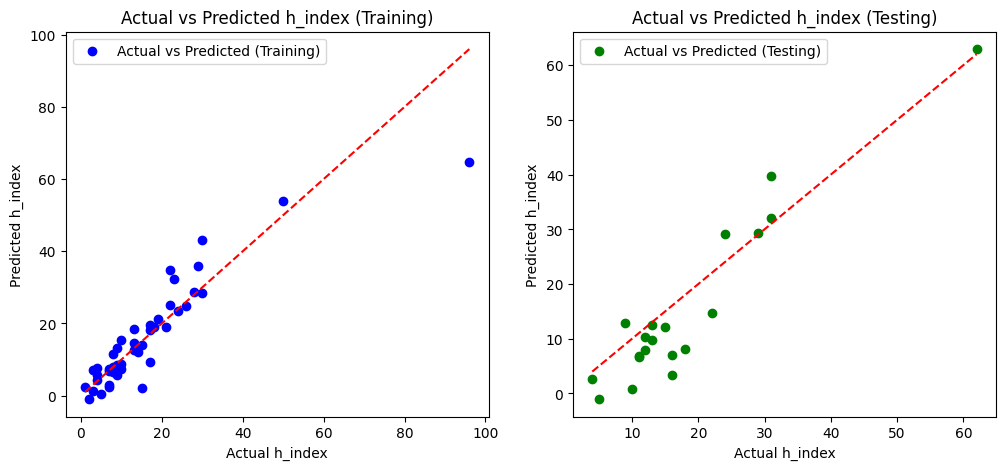

In [ ]:
def plot_evaluation(ax, y, y_pred, *, type='', color='blue'):
    ax.scatter(y, y_pred, color=color, label=f'Actual vs Predicted ({type})')
    ax.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--')
    ax.set_xlabel('Actual h_index')
    ax.set_ylabel('Predicted h_index')
    ax.set_title(f'Actual vs Predicted h_index ({type})')
    ax.legend()
    
# 実測値と予測値の比較のグラフを作成する
fig, axs = plt.subplots(1,2,figsize=(12,5))
plot_evaluation(axs[0], y_train, y_train_pred, type='Training',color='blue')
plot_evaluation(axs[1], y_test, y_test_pred, type='Testing',color='green')
plt.show()

In [ ]:
# Evaluate the model using R^2 score
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training set R^2 score:", train_r2)
print("Testing set R^2 score:", test_r2)

Training set R^2 score: 0.8185765385964787
Testing set R^2 score: 0.7775716745693573


In [ ]:
np.set_printoptions(suppress=True)
coefficients = {col: f'{coef:.3f}' for col, coef in zip(X.columns, model.coef_)}
pprint(coefficients)

{'affiliation_h_index': '-0.002',
 'career_age': '0.166',
 'sqrt_cited_past_5yrs': '0.945'}


## 4. h-indexで被引用数の長期的予測

Number of valid data for plotting: 18


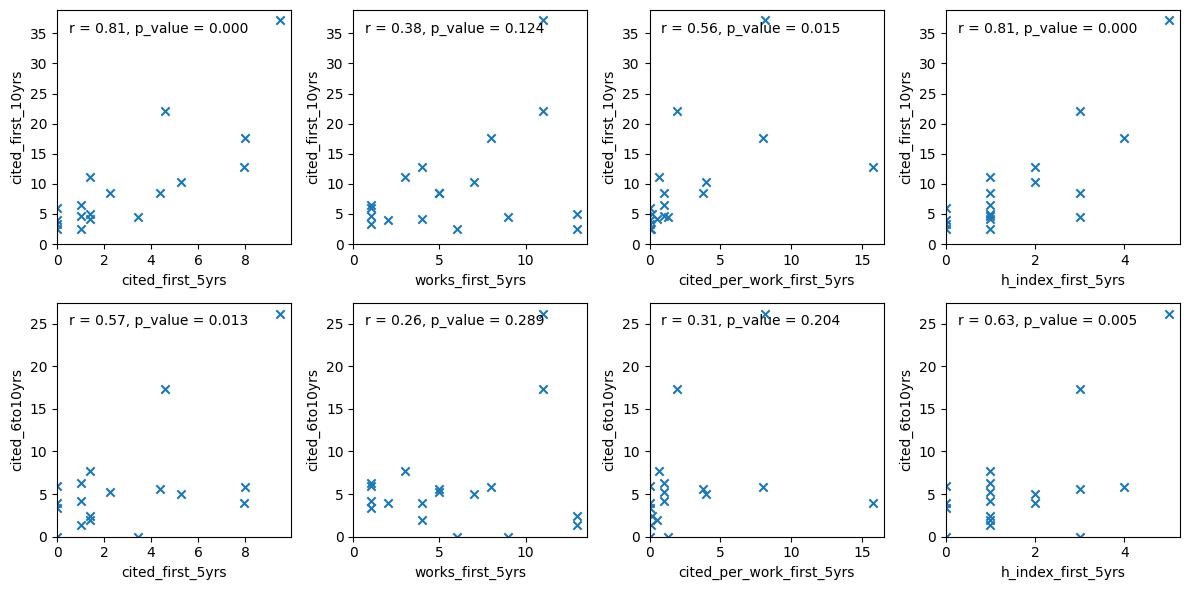

In [ ]:
from scipy.stats import pearsonr

authors_valid_2=authors_df[(authors_df['h_index_first_5yrs']>=0)]
print(f'Number of valid data for plotting: {authors_valid_2.shape[0]}')

# Calculate the square root of the cited_by_count
XX = authors_valid_2[['cited_first_5yrs', 'works_first_5yrs', 'cited_per_work_first_5yrs', 'h_index_first_5yrs']].copy()
YY = authors_valid_2[['cited_first_10yrs', 'cited_6to10yrs']].copy()
XX[['cited_first_5yrs']] = XX[['cited_first_5yrs']].apply(np.sqrt)
YY = YY.apply(np.sqrt)

# Plot scattered graphs for all combinations of XX and YY
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(12, 6))

for i, x_col in enumerate(XX.columns):
    for j, y_col in enumerate(YY.columns):
        ax = axs[j, i]
        ax.scatter(XX[x_col], YY[y_col], marker='x')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_xlim(left=0)
        ax.set_ylim(bottom=0)

        # Compute correlation coefficient (r)
        r, p_value = pearsonr(XX[x_col], YY[y_col])
        ax.text(0.05, 0.95, f'r = {r:.2f}, p_value = {p_value:.3f}', transform=ax.transAxes, ha='left', va='top')

plt.tight_layout()
plt.show()

- (Row 1) キャリアの5年目の論文指標を利用し、10年目の総被引用数を予測するときには、sqrt(cited_first_5yrs)とh_index_first_5yrs（最初の5年の被引用数の平方根と第5年のh-index）は最も有用な指標である。
- (Row 2) さらに、キャリアの5年目の論文指標を利用し、5年目以降発表した論文の総被引用数を予測するときには、h_index_first_5yrsは最もいい予測指標である。

# Playground

## 5. 大学別h-index高い順に並べる

In [ ]:
# 世界中の大学のh-indexランキング
ins_json = Institutions().select(['display_name','country_code','works_count','cited_by_count','summary_stats'])\
                         .sort(summary_stats={'h_index':'desc'}).get(per_page=50)
ins_df = pd.DataFrame(ins_json)

#get h-index
ins_df['h_index'] = ins_df['summary_stats'].apply(lambda x:x['h_index'])
ins_df = ins_df.drop(columns=['summary_stats'])

display(ins_df)

,display_name,country_code,works_count,cited_by_count,h_index
0,Harvard University,US,586010,34147412,1533
1,Stanford University,US,403755,20488131,1299
2,Massachusetts Institute of Technology,US,270477,15428117,1198
3,Howard Hughes Medical Institute,US,82647,11911906,1190
4,"University of California, Berkeley",US,337012,16253735,1123
5,University of Washington,US,407785,16298437,1075
6,Johns Hopkins University,US,373898,16285153,1061
7,National Institutes of Health,US,235437,14694148,1061
8,University of Michigan–Ann Arbor,US,859774,16437066,1035
9,French National Centre for Scientific Research,FR,1039824,29849111,1032


In [ ]:
# 日本の大学のh-indexランキング
ins_json = Institutions().select(['display_name','international','works_count','cited_by_count','summary_stats'])\
                         .filter(country_code='JP')\
                         .sort(summary_stats={'h_index':'desc'}).get(per_page=50)
ins_df = pd.DataFrame(ins_json)

# get h-index
ins_df['h_index'] = ins_df['summary_stats'].apply(lambda x:x['h_index'])
ins_df = ins_df.drop(columns=['summary_stats'])

# get Japanese name
jp_name = [entry['international']['display_name'].get('ja','-') for entry in ins_json]
ins_df['Japanese_name'] = jp_name
ins_df = ins_df.drop(columns=['international'])

ins_df.insert(ins_df.columns.get_loc('display_name') + 1, 'Japanese_name', ins_df.pop('Japanese_name'))

display(ins_df)

,display_name,Japanese_name,works_count,cited_by_count,h_index
0,The University of Tokyo,東京大学,401375,9962597,727
1,Kyoto University,京都大学,288168,7158662,646
2,Osaka University,大阪大学,245866,5570125,598
3,Japan Science and Technology Agency,-,52491,2656504,544
4,Tohoku University,東北大学,229323,4505844,493
5,Nagoya University,名古屋大学,170079,3365881,436
6,Kyushu University,九州大学,189678,3205539,420
7,National Institute of Advanced Industrial Scie...,産業技術総合研究所,79750,1884152,392
8,Tokyo Institute of Technology,東京工業大学,139983,2542083,391
9,Tokyo University of Science,東京理科大学,76487,1785540,389


## 6. 個人のh-indexを時系列でプロット

In [ ]:
# 著者を検索する
name = "J. E. Hirsch"

auth_json = Authors().search_filter(display_name=name)\
            .select(["id","display_name","relevance_score","works_count","cited_by_count","summary_stats"]).get()
auth_df = pd.DataFrame(auth_json)
auth_df = auth_df.join(pd.DataFrame(auth_df['summary_stats'].tolist()))
auth_df = auth_df.drop(columns=['summary_stats'])

display(auth_df.head())

,id,display_name,relevance_score,works_count,cited_by_count,2yr_mean_citedness,h_index,i10_index
0,https://openalex.org/A5036688434,J. E. Hirsch,11936.00000,466,31755,1.875,69,249
1,https://openalex.org/A5072780714,J. E. Hirsch,655.18750,4,79,0.000,3,2
2,https://openalex.org/A5031101292,J. E. Hirsch,33.48759,1,0,0.000,0,0
3,https://openalex.org/A5039441333,J. E. Hirsch,33.48759,1,0,0.000,0,0
4,https://openalex.org/A5052660639,J. E. Hirsch,33.48759,1,0,0.000,0,0


In [ ]:
# 検索結果から著者を指定する
i = 0
auth_id = auth_df.loc[i,"id"]
print(auth_id)
auth_name = auth_df.loc[i,"display_name"]

# 著者データを確認する
data = Authors()[auth_id]
# 著者の最新の所属機関（ここでは同名の人が混ざっているため、表示されたのはあのアインシュタインの所属機関ではない）
institutions = [entry['display_name'] for entry in data['last_known_institutions']]
print('\nLast known institutions of the select author:')
pprint(institutions)
# 著者が発表した論文のテーマ
concepts = [entry['display_name'] for entry in data['x_concepts']]
print('\nConcepts of the select author:')
pprint(concepts)

https://openalex.org/A5036688434

Last known institutions of the select author:
['University of California, San Diego']

Concepts of the select author:
['Physics',
 'Quantum mechanics',
 'Condensed matter physics',
 'Superconductivity',
 'Mathematics',
 'Materials science',
 'Nuclear physics',
 'Chemistry',
 'Engineering',
 'Electron',
 'Thermodynamics',
 'Organic chemistry',
 'Medicine',
 'Biology',
 'Computer science',
 'Statistics']


4it [00:02,  1.47it/s]


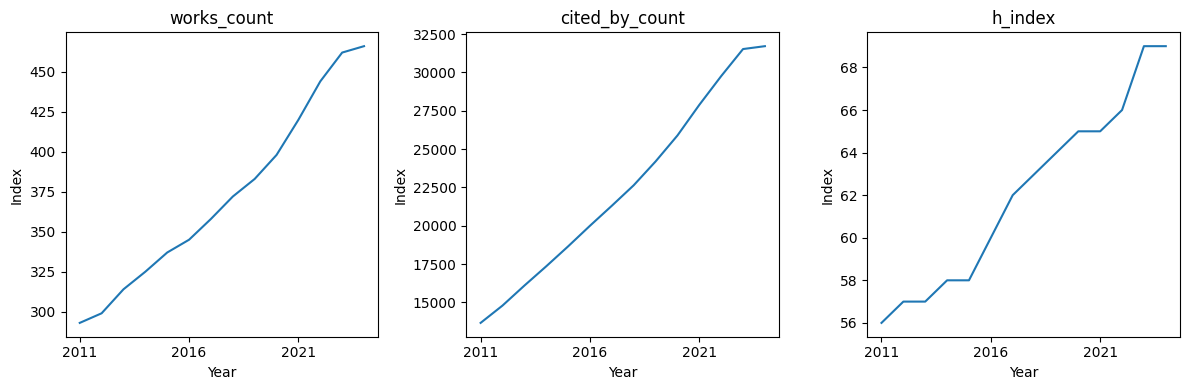

In [ ]:
pyalexObj = Works().filter(author={"id":auth_id},is_paratext=False)\
                   .select(['cited_by_count','counts_by_year','publication_year'])\
                   .sort(publication_year="asc")
works_json = util.getAll(pyalexObj)

first_publication_year = works_json[0]["publication_year"] 
indices = pd.DataFrame(index=range(max(first_publication_year, 2011), 2025),
                         columns = ['works_count','cited_by_count','h_index'])

# Calculate h-index for each year
for year in range(max(first_publication_year, 2011), 2025):
    citations = get_citations(works_json, first_publication_year, year)
    indices.loc[year,'works_count']=len(citations)
    indices.loc[year,'cited_by_count']=sum(citations)
    indices.loc[year,'h_index']=calculate_h_index(citations)

# Create a figure and axes for subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i, col in enumerate(indices.columns):
        ax = axs[i]
        ax.plot(indices.index, indices[col])
        ax.set_xlabel('Year')
        ax.set_ylabel('Index')
        ax.set_title(col)
        ax.set_xticks(indices.index[::5])

plt.tight_layout()
plt.show()